In [ ]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import string
from string import punctuation
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Представление и предобработка текстовых данных в виде последовательностей

1.1 Представьте первое предложение из строки `text` как последовательность из индексов слов, входящих в это предложение

In [ ]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [ ]:
tokens = word_tokenize(text)

filtered_tokens = [word.lower() for word in tokens if word.lower() not in string.punctuation]

word_index = {word: idx for idx, word in enumerate(filtered_tokens, start=1)}

# Преобразование первого предложения в последовательность индексов
first_sentence = word_tokenize(text.lower().split('.')[0])
sentence_idx = [word_index[word] for word in first_sentence if word not in string.punctuation]

print("Словарь слов и их индексов:", word_index)
print('')
print("Последовательность индексов для первого предложения:", sentence_idx)

Словарь слов и их индексов: {'select': 1, 'your': 2, 'preferences': 3, 'and': 15, 'run': 5, 'the': 11, 'install': 7, 'command': 8, 'stable': 9, 'represents': 10, 'most': 12, 'currently': 13, 'tested': 14, 'supported': 16, 'version': 17, 'of': 18, 'pytorch': 19, 'note': 20, 'that': 21, 'libtorch': 22, 'is': 23, 'only': 24, 'available': 25, 'for': 26, 'c++': 27}

Последовательность индексов для первого предложения: [1, 2, 3, 15, 5, 11, 7, 8]


1.2 Представьте первое предложение из строки `text` как последовательность векторов, соответствующих индексам слов. Для представления индекса в виде вектора используйте унитарное кодирование. В результате должен получиться двумерный тензор размера `количество слов в предложении` x `количество уникальных слов`

In [ ]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [ ]:
first_sentence = text.split('.')[0]
words = first_sentence.split()
unique_words = list(set(words))

word_to_index = {word: i for i, word in enumerate(unique_words)}
word_indices = [word_to_index[word] for word in words]
num_unique_words = len(unique_words)

binary_word_vectors = torch.zeros(len(words), num_unique_words)

for i, index in enumerate(word_indices):
    binary_word_vectors[i, index] = 1.0

print("Унитарное кодирование слов первого предложения в виде векторов:")
print(binary_word_vectors)

Унитарное кодирование слов первого предложения в виде векторов:
tensor([[0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.]])


1.3 Решите задачу 1.2, используя модуль `nn.Embedding`

In [ ]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [ ]:
first_sentence = text.split('.')[0]

words = first_sentence.split()
unique_words = list(set(words))
word_to_index = {word: i for i, word in enumerate(unique_words)}

word_indices = [word_to_index[word] for word in words]

num_unique_words = len(unique_words)

eye_matrix = torch.eye(num_unique_words)

embedding = nn.Embedding(num_unique_words, num_unique_words, _weight=eye_matrix)

word_vectors = embedding(torch.LongTensor(word_indices))

print("Унитарное кодирование слов первого предложения в виде векторов:")
print(word_vectors)

Унитарное кодирование слов первого предложения в виде векторов:
tensor([[0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.]], grad_fn=<EmbeddingBackward0>)


## 2. Классификация фамилий по национальности (ConvNet)

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`.

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)
  * добавьте в словарь специальный токен `<PAD>` с индексом 0
  * при создании словаря сохраните длину самой длинной последовательности из набора данных в виде атрибута `max_seq_len`

2.5 Реализовать класс `SurnamesDataset`
  * метод `__getitem__` возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса>
  * длина каждой такой последовательности должна быть одинаковой и равной `vocab.max_seq_len`. Чтобы добиться этого, дополните последовательность справа индексом токена `<PAD>` до нужной длины

2.6. Обучить классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`. Рассмотрите два варианта:
    - когда токен представляется в виде унитарного вектора и модуль `nn.Embedding` не обучается
    - когда токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/surnames.csv')

nationalities = data['nationality'].unique()
nationality_to_index = {nat: idx for idx, nat in enumerate(nationalities)}

data['nationality'] = data['nationality'].map(nationality_to_index)

data.head(5)

,surname,nationality
0,Woodford,0
1,Coté,1
2,Kore,0
3,Koury,2
4,Lebzak,3


In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
class Vocab:
    def __init__(self, tokens):
        self.token_to_index = {token: idx + 1 for idx, token in enumerate(tokens)}
        self.token_to_index['<PAD>'] = 0
        self.index_to_token = {idx: token for token, idx in self.token_to_index.items()}
        self.max_seq_len = max(len(token) for token in tokens)

In [ ]:
all_tokens = set(" ".join(data['surname']).split())
vocab = Vocab(all_tokens)

In [ ]:
class SurnamesDataset(Dataset):
    def __init__(self, df, vocab):
        self.df = df
        self.vocab = vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        surname = self.df.iloc[idx]['surname'].lower()
        nationality = self.df.iloc[idx]['nationality']


        indices = [self.vocab.token_to_index[char] for char in surname if char in self.vocab.token_to_index]
        indices += [self by.vocab.token_to_index['<PAD>']] * (self.vocab.max_seq_len - len(indices))

        return {'indices': torch.tensor(indices).long(), 'nationality': torch.tensor(nationality).long()}

In [ ]:
class SimpleClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_size):
        super(SimpleClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d_1 = nn.Conv1d(embedding_dim, 128, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv1d_2 = nn.Conv1d(128, 256, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool = nn.MaxPool1d(2)
        self.fc = nn.Linear(256 * ((vocab.max_seq_len - 4) // 2), output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1d_1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv1d_2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
vocab_size = len(vocab.token_to_index)
embedding_dim = 10
output_size = len(nationalities)

In [ ]:
model = SimpleClassifier(vocab_size, embedding_dim, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.01)

In [ ]:
epochs = 20
batch_size = 32

In [ ]:
train_dataset = SurnamesDataset(train_df, vocab)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SurnamesDataset(test_df, vocab)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_losses = []
test_losses = []

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    for batch in train_loader:
        indices, nationality = batch['indices'], batch['nationality']
        indices = indices.long()
        nationality = nationality.long()

        optimizer.zero_grad()
        outputs = model(indices)
        loss = criterion(outputs, nationality)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))


    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            indices, nationality = batch['indices'], batch['nationality']
            indices = indices.long()
            nationality = nationality.long()

            outputs = model(indices)
            loss = criterion(outputs, nationality)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += nationality.size(0)
            correct += (predicted == nationality).sum().item()

    test_losses.append(test_loss / len(test_loader))

    print(f'Epoch {epoch + 1}, Training Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {(correct / total) * 100:.2f}%')

Epoch 1, Training Loss: 2.881910830411044, Test Loss: 2.87362457703853, Test Accuracy: 26.87%
Epoch 2, Training Loss: 2.8527712787281385, Test Loss: 2.824912755385689, Test Accuracy: 26.87%
Epoch 3, Training Loss: 2.7820143742994827, Test Loss: 2.734613791756008, Test Accuracy: 26.87%
Epoch 4, Training Loss: 2.678302738016302, Test Loss: 2.6223310111225517, Test Accuracy: 26.87%
Epoch 5, Training Loss: 2.5639283310283316, Test Loss: 2.5107202322586724, Test Accuracy: 26.87%
Epoch 6, Training Loss: 2.459454096880826, Test Loss: 2.4161109958869824, Test Accuracy: 26.87%
Epoch 7, Training Loss: 2.3760782727328214, Test Loss: 2.3462518367214478, Test Accuracy: 26.87%
Epoch 8, Training Loss: 2.317490388696844, Test Loss: 2.3000211301057236, Test Accuracy: 26.87%
Epoch 9, Training Loss: 2.281045699119568, Test Loss: 2.2718831024308135, Test Accuracy: 26.87%
Epoch 10, Training Loss: 2.2587201127139003, Test Loss: 2.256363246751868, Test Accuracy: 26.87%
Epoch 11, Training Loss: 2.246499964107

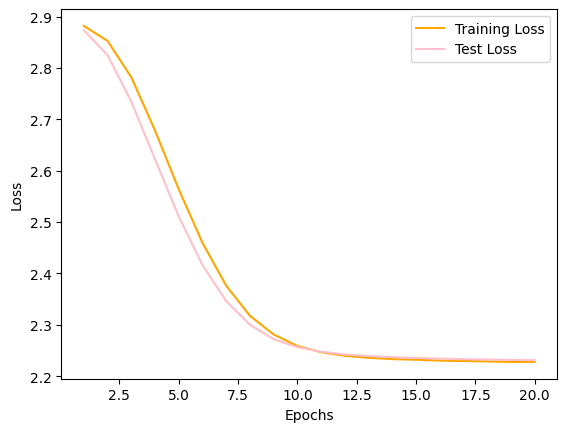

In [ ]:
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='orange')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='pink')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3. Классификация обзоров на фильмы (ConvNet)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`
    - подберите адекватную размерность вектора эмбеддинга:
    - модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`


2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [ ]:
with open('/content/drive/MyDrive/positive_reviews.txt', 'r', encoding='utf-8') as f:
    positive_reviews = f.read().split('.')
with open('/content/drive/MyDrive/negative_reviews.txt', 'r', encoding='utf-8') as f:
    negative_reviews = f.read().split('.')

positive_labels = [1] * len(positive_reviews)
negative_labels = [0] * len(negative_reviews)

all_reviews = positive_reviews + negative_reviews
all_labels = positive_labels + negative_labels

train_reviews, test_reviews, train_labels, test_labels = train_test_split(
    all_reviews, all_labels, test_size=0.2, random_state=42
)

In [ ]:
# Предобработка текста и создание словаря
def preprocess_text(text, vocab):
    tokens = text.lower().split()
    token_ids = [vocab[token] if token in vocab else vocab['<UNK>'] for token in tokens]
    return token_ids

# Создание словаря
vocab = {}
index = 0
for review in train_reviews:
    tokens = review.lower().split()
    for token in tokens:
        if token not in vocab:
            vocab[token] = index
            index += 1
vocab['<UNK>'] = index

In [ ]:
train_data = [preprocess_text(review, vocab) for review in train_reviews]
test_data = [preprocess_text(review, vocab) for review in test_reviews]

max_len = max(max(len(review) for review in train_data), max(len(review) for review in test_data))

train_data = [review + [0] * (max_len - len(review)) for review in train_data]
test_data = [review + [0] * (max_len - len(review)) for review in test_data]

In [ ]:
train_data = torch.tensor(train_data)
test_data = torch.tensor(test_data)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
train_dataset = ReviewsDataset(train_data, train_labels)
test_dataset = ReviewsDataset(test_data, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d_1 = nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=1)
        self.batch_norm_1 = nn.BatchNorm1d(128)
        self.conv1d_2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.batch_norm_2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64 * (max_len // 4), 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1d_1(x)
        x = self.batch_norm_1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv1d_2(x)
        x = self.batch_norm_2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
model = TextClassifier(len(vocab), embedding_dim=50, num_classes=2)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loss = []
test_loss = []

In [ ]:
epoch = 15

In [ ]:
for epoch in range(epoch):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data.squeeze(1).long())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy_train = correct_train / total_train
    train_loss.append(avg_loss)


    model.eval()
    with torch.no_grad():
        total_test = 0
        correct_test = 0
        total_loss_test = 0.0

        for data, labels in test_loader:
            outputs = model(data.squeeze(1).long())
            loss_test = criterion(outputs, labels)
            total_loss_test += loss_test.item()

            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()

        avg_loss_test = total_loss_test / len(test_loader)
        accuracy_test = correct_test / total_test
        test_loss.append(avg_loss_test)

    print(f"Epoch {epoch + 1}/{15}, Train Loss: {avg_loss:.4f}, Training Accuracy: {accuracy_train * 100:.2f}%")
    print(f"Epoch {epoch + 1}/{15}, Test Loss: {avg_loss_test:.4f}, Test Accuracy: {accuracy_test * 100:.2f}%")

Epoch 1/15, Train Loss: 0.6965, Training Accuracy: 50.55%
Epoch 1/15, Test Loss: 0.6971, Test Accuracy: 50.52%
Epoch 2/15, Train Loss: 0.6922, Training Accuracy: 51.53%
Epoch 2/15, Test Loss: 0.6952, Test Accuracy: 51.44%
Epoch 3/15, Train Loss: 0.6899, Training Accuracy: 53.10%
Epoch 3/15, Test Loss: 0.6940, Test Accuracy: 51.41%
Epoch 4/15, Train Loss: 0.6877, Training Accuracy: 53.84%
Epoch 4/15, Test Loss: 0.6932, Test Accuracy: 52.05%
Epoch 5/15, Train Loss: 0.6847, Training Accuracy: 55.00%
Epoch 5/15, Test Loss: 0.6926, Test Accuracy: 52.52%
Epoch 6/15, Train Loss: 0.6822, Training Accuracy: 56.04%
Epoch 6/15, Test Loss: 0.6917, Test Accuracy: 53.16%
Epoch 7/15, Train Loss: 0.6798, Training Accuracy: 56.20%
Epoch 7/15, Test Loss: 0.6917, Test Accuracy: 52.48%
Epoch 8/15, Train Loss: 0.6773, Training Accuracy: 57.39%
Epoch 8/15, Test Loss: 0.6916, Test Accuracy: 51.80%
Epoch 9/15, Train Loss: 0.6746, Training Accuracy: 58.21%
Epoch 9/15, Test Loss: 0.6903, Test Accuracy: 53.94%
E

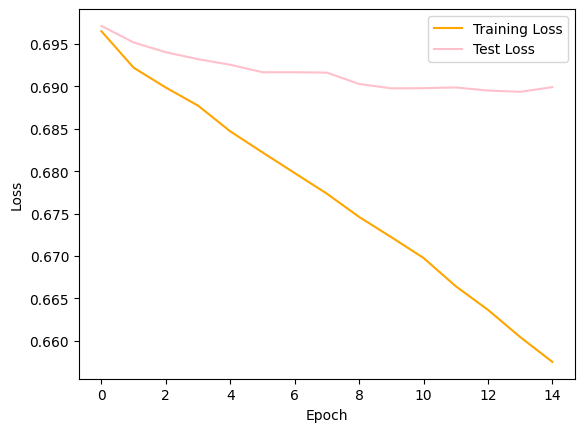

In [ ]:
plt.plot(train_loss, label='Training Loss', color = 'orange')
plt.plot(test_loss, label='Test Loss', color = 'pink')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()